### Equities Pairs Trading - Cointegration

This project implements equities pairs trading model in Python. The strategy identifies potentially cointegrated equity pairs, generates entry and exit signals based on z-score thresholds, and evaluates performance using out-of-sample testing.

Purpose:
- To further my career opportunities through upskilling.
- To demonstrate personal progress in python coding proficiency in a quant finance (buy-side) context.
- No python knowledge before 9 June 2025. Today 29 August 2025. 12 weeks of learning.

Methodology:
- download data for an equity index and its constituents
- clean data
- convert price data to daily returns and define in-sample DataFrame
- define performance calculation and presentation functions
- define functions to identify cointegrated pairs for trading strategy
- define functions to generate z-score entry/exit trading signals and portfolio positions
- optimise multiple user defined z-score exit threshold levels
- execute stratey for optimised exit z-score threshold
- display performance charts (returns, signals generated for one example pair, drawdown, duration) and summary data (returns, sharpe, etc)

Known deficiencies: 
- Using personal laptop not an institutional machine, so no access to Bloomberg for full markets data universe and limited computational power.
- Use yfinance (yf) library for data. Limited to projects that rely on tickers available in yf, e.g. equities and FX, not rates.     
- Intentional selection of equity index with a small number of constituents to limit computational power expense.
- intentional simplification of transaction costs for illustrative purposes. Ignores dynamic TCA data for a trailing period.

## Step 0: Setup and Control Panel

In [1]:
# -----------------------------
# SETUP
# -----------------------------

# allows definition of Config class
from __future__ import annotations
from dataclasses import dataclass

# Setup
from datetime import datetime, timedelta
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import yfinance as yf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from joblib import Parallel, delayed
from itertools import permutations

In [2]:
# -----------------------------
# CONFIG (control panel)
# -----------------------------
@dataclass
class Config:
    lookback_years: int = 7             # Number of years of historical data
    training_years: int = 4              # Number of years for in-sample period
    data_thresh: float = 0.95            # percentage of days each timeseries needs to be included in cointegration tests
    min_obs: int = 252                   # for clean_pair_data and adf_for_pair
    max_gap: int = 1                     # for clean_pair_data and adf_for_pair
    significance_level: float = 0.05     # p-value cutoff for cointegration
    top_n: int = 1                       # keep top n pairs per asset
    rolling_window: int = 90             # Rolling window for z-score/beta/alpha
    tcost_bps: float = 5.0               # Commission + slippage (bps) [NB: gross simplificaiton for illustrative purposes. Ignores TCA]
    entry_thresh: float = 1.0            # entry threshold to triggers buy/sell signal
    exit_thresh: Tuple[float, ...] = (0.1, 0.2, 0.5, 0.7, 0.9)  # Exit thresholds to grid-search
    
    def __post_init__(self):
        if not (0 < self.data_thresh <= 1):
            raise ValueError("data_thresh must be between 0 and 1.")
        if self.training_years > self.lookback_years:
            raise ValueError("training_years cannot exceed lookback_years.")

## Step 1: Data Download & Clean

In [5]:
# -----------------------------
# CALCULATES ROLLING HISTORIC DATE PERIODS
# -----------------------------
cfg = Config()
start_date = datetime.today() - pd.DateOffset(years=cfg.lookback_years)    # calculates rolling start date
end_of_insample = start_date + pd.DateOffset(years=cfg.training_years) # cals sample period end date


# -----------------------------
# Benchmark and constituent tickers (as of 27/08/2025)
# -----------------------------

benchmark_index = "^FTSE"  # FTSE 100 index ticker on Yahoo Finance

bm_tickers = [
    "AAL.L", "ABF.L", "ADM.L", "AHT.L", "ANTO.L", "AUTO.L", "AV.L", "AZN.L", "BA.L", "BARC.L",
    "BATS.L", "BDEV.L", "BEZ.L", "BKG.L", "BLND.L", "BNZL.L", "BP.L", "BT-A.L", "CCH.L", "CNA.L",
    "CPG.L", "CRDA.L", "CTEC.L", "DCC.L", "DGE.L", "DLG.L", "DPLM.L", "ENT.L", "EXPN.L", "EZJ.L",
    "FERG.L", "FLTR.L", "FRES.L", "GSK.L", "HL.L", "HLMA.L", "HSBA.L", "IMB.L", "INF.L", "ITV.L",
    "JD.L", "JET.L", "KGF.L", "LAND.L", "LGEN.L", "LLOY.L", "MNG.L", "MRO.L", "NG.L", "NXT.L",
    "OSB.L", "PHNX.L", "PRU.L", "PSN.L", "PSON.L", "RTO.L", "RR.L", "RS1.L", "SBRY.L", "SDR.L",
    "SGE.L", "SHEL.L", "SMDS.L", "SMIN.L", "SMT.L", "SN.L", "SPX.L", "SSE.L", "STAN.L", "STJ.L",
    "SVT.L", "TATE.L", "TEP.L", "TSCO.L", "TW.L", "ULVR.L", "UU.L", "VOD.L", "WEIR.L", "WTB.L",
    "WPP.L", "HSX.L", "ITRK.L", "IHG.L", "HIK.L", "HLN.L", "ICG.L", "IGG.L", "INCH.L", "IAG.L",
    "ENT.L", "BME.L", "CNA.L", "SSE.L", "SGRO.L", "SVT.L", "TRN.L", "WOSG.L", "WIZZ.L", "YOU.L"
]

In [7]:
# -----------------------------
# Download historical data from yfinance
# -----------------------------
asset_px = yf.download(bm_tickers, start=start_date.strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))['Close']
benchmark_df = yf.download(benchmark_index, start=start_date.strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))['Close']

# Ensure columns are simple tickers
asset_px.columns.name = None

[********************* 43%                       ]  41 of 96 completedHTTP Error 404: 
[*********************100%***********************]  96 of 96 completed

4 Failed downloads:
['HL.L', 'JET.L', 'SMDS.L', 'BDEV.L']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


In [9]:
asset_px # check constituent DataFrame download 

,AAL.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,TW.L,ULVR.L,UU.L,VOD.L,WEIR.L,WIZZ.L,WOSG.L,WPP.L,WTB.L,YOU.L
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-30,1533.362061,2307.954346,2083.199951,2384.468750,821.866516,454.348633,482.477783,5899.662598,610.508118,177.917923,...,169.201263,4423.864746,736.452148,166.723572,1897.884766,3193.0,NaN,1274.148315,3449.158936,492.707275
2018-08-31,1500.464478,2285.983398,2074.224854,2359.494873,803.904541,448.752960,477.165161,5784.862305,604.522705,175.323471,...,166.710800,4381.466309,739.243286,163.717926,1872.413086,3171.0,NaN,1274.646851,3943.366211,494.706055
2018-09-03,1529.079712,2281.987793,2112.119385,2397.454590,808.095642,451.350922,484.543884,5878.698730,612.104309,177.139587,...,168.354492,4407.900879,724.689697,165.748245,1883.900146,3164.0,NaN,1272.652832,3930.496338,496.704865
2018-09-04,1506.498657,2240.043457,2090.180176,2404.447754,792.728027,431.566162,482.674652,5789.854492,604.522705,180.632065,...,163.672470,4346.550781,712.727783,163.518875,1841.447754,3130.0,NaN,1192.894043,4032.598389,496.704865
2018-09-05,1489.173950,2280.989258,2089.183350,2358.496094,794.524292,427.369446,477.952179,5691.027344,605.719849,177.618546,...,165.764404,4272.727051,710.534851,162.125534,1784.011719,3118.0,NaN,1144.041626,4042.036621,496.704865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-22,2201.000000,2314.000000,3656.000000,5462.000000,2167.000000,824.128418,672.469910,11968.000000,1764.000000,376.450012,...,100.699997,4662.000000,1166.500000,88.639999,2512.000000,1394.0,334.600006,401.100006,3203.000000,353.000000
2025-08-26,2210.000000,2222.000000,3634.000000,5518.000000,2160.000000,821.528625,678.468750,11872.000000,1771.500000,373.799988,...,98.919998,4594.000000,1167.500000,88.220001,2470.000000,1391.0,325.200012,391.200012,3138.000000,347.500000
2025-08-27,2201.000000,2189.000000,3646.000000,5486.000000,2138.000000,817.528992,677.069031,11876.000000,1766.500000,371.399994,...,98.680000,4623.000000,1163.500000,89.339996,2454.000000,1362.0,333.799988,391.600006,3192.000000,343.000000


In [11]:
# -----------------------------
# INSTANTIATE CONFIG CLASS; create config object with current defaults
# -----------------------------

cfg = Config()

In [13]:
# -----------------------------
# CLEAN DATA
# -----------------------------

# Calculate the total number of data points
total_data_points = len(asset_px)

# Calculate the number of non-NA/null entries for each asset
non_null_counts = asset_px.notnull().sum()

# Calculate the threshold for data points
threshold = cfg.data_thresh * total_data_points

# Filter out columns with fewer than 90% of data points
asset_px = asset_px.loc[:, non_null_counts >= threshold]

asset_px # check cleaned data DataFrame

,AAL.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WEIR.L,WIZZ.L,WPP.L,WTB.L,YOU.L
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-30,1533.362061,2307.954346,2083.199951,2384.468750,821.866516,454.348633,482.477783,5899.662598,610.508118,177.917923,...,309.126160,169.201263,4423.864746,736.452148,166.723572,1897.884766,3193.0,1274.148315,3449.158936,492.707275
2018-08-31,1500.464478,2285.983398,2074.224854,2359.494873,803.904541,448.752960,477.165161,5784.862305,604.522705,175.323471,...,311.400085,166.710800,4381.466309,739.243286,163.717926,1872.413086,3171.0,1274.646851,3943.366211,494.706055
2018-09-03,1529.079712,2281.987793,2112.119385,2397.454590,808.095642,451.350922,484.543884,5878.698730,612.104309,177.139587,...,309.505157,168.354492,4407.900879,724.689697,165.748245,1883.900146,3164.0,1272.652832,3930.496338,496.704865
2018-09-04,1506.498657,2240.043457,2090.180176,2404.447754,792.728027,431.566162,482.674652,5789.854492,604.522705,180.632065,...,307.610229,163.672470,4346.550781,712.727783,163.518875,1841.447754,3130.0,1192.894043,4032.598389,496.704865
2018-09-05,1489.173950,2280.989258,2089.183350,2358.496094,794.524292,427.369446,477.952179,5691.027344,605.719849,177.618546,...,303.567627,165.764404,4272.727051,710.534851,162.125534,1784.011719,3118.0,1144.041626,4042.036621,496.704865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-22,2201.000000,2314.000000,3656.000000,5462.000000,2167.000000,824.128418,672.469910,11968.000000,1764.000000,376.450012,...,426.299988,100.699997,4662.000000,1166.500000,88.639999,2512.000000,1394.0,401.100006,3203.000000,353.000000
2025-08-26,2210.000000,2222.000000,3634.000000,5518.000000,2160.000000,821.528625,678.468750,11872.000000,1771.500000,373.799988,...,432.000000,98.919998,4594.000000,1167.500000,88.220001,2470.000000,1391.0,391.200012,3138.000000,347.500000
2025-08-27,2201.000000,2189.000000,3646.000000,5486.000000,2138.000000,817.528992,677.069031,11876.000000,1766.500000,371.399994,...,427.100006,98.680000,4623.000000,1163.500000,89.339996,2454.000000,1362.0,391.600006,3192.000000,343.000000


In [15]:
# -----------------------------
# Create DataFrame of daily returns from dataframe of absolute prices
# -----------------------------
assets_ret = asset_px / asset_px.shift() - 1
assets_ret

,AAL.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WEIR.L,WIZZ.L,WPP.L,WTB.L,YOU.L
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-31,-0.021455,-0.009520,-0.004308,-0.010474,-0.021855,-0.012316,-0.011011,-0.019459,-0.009804,-0.014582,...,0.007356,-0.014719,-0.009584,0.003790,-0.018028,-0.013421,-0.006890,0.000391,0.143283,0.004057
2018-09-03,0.019071,-0.001748,0.018269,0.016088,0.005213,0.005789,0.015464,0.016221,0.012541,0.010359,...,-0.006085,0.009860,0.006033,-0.019687,0.012401,0.006135,-0.002208,-0.001564,-0.003264,0.004040
2018-09-04,-0.014768,-0.018381,-0.010387,0.002917,-0.019017,-0.043835,-0.003858,-0.015113,-0.012386,0.019716,...,-0.006122,-0.027810,-0.013918,-0.016506,-0.013450,-0.022534,-0.010746,-0.062671,0.025977,0.000000
2018-09-05,-0.011500,0.018279,-0.000477,-0.019111,0.002266,-0.009724,-0.009784,-0.017069,0.001980,-0.016683,...,-0.013142,0.012781,-0.016984,-0.003077,-0.008521,-0.031191,-0.003834,-0.040953,0.002340,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-22,0.009170,-0.006867,-0.005982,0.020172,0.014513,0.000972,-0.001484,-0.006640,0.002558,0.006685,...,-0.012051,0.019437,-0.006817,-0.003417,0.001808,0.012087,0.010877,0.018537,0.019739,0.044379
2025-08-26,0.004089,-0.039758,-0.006018,0.010253,-0.003230,-0.003155,0.008921,-0.008021,0.004252,-0.007040,...,0.013371,-0.017676,-0.014586,0.000857,-0.004738,-0.016720,-0.002152,-0.024682,-0.020293,-0.015581
2025-08-27,-0.004072,-0.014851,0.003302,-0.005799,-0.010185,-0.004869,-0.002063,0.000337,-0.002822,-0.006421,...,-0.011343,-0.002426,0.006313,-0.003426,0.012695,-0.006478,-0.020848,0.001022,0.017208,-0.012950


In [17]:
# -----------------------------
# Create dataframe of prices for in-sample period only
# -----------------------------
in_sample_px = asset_px.loc[:end_of_insample]
in_sample_px

,AAL.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WEIR.L,WIZZ.L,WPP.L,WTB.L,YOU.L
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-30,1533.362061,2307.954346,2083.199951,2384.468750,821.866516,454.348633,482.477783,5899.662598,610.508118,177.917923,...,309.126160,169.201263,4423.864746,736.452148,166.723572,1897.884766,3193.0,1274.148315,3449.158936,492.707275
2018-08-31,1500.464478,2285.983398,2074.224854,2359.494873,803.904541,448.752960,477.165161,5784.862305,604.522705,175.323471,...,311.400085,166.710800,4381.466309,739.243286,163.717926,1872.413086,3171.0,1274.646851,3943.366211,494.706055
2018-09-03,1529.079712,2281.987793,2112.119385,2397.454590,808.095642,451.350922,484.543884,5878.698730,612.104309,177.139587,...,309.505157,168.354492,4407.900879,724.689697,165.748245,1883.900146,3164.0,1272.652832,3930.496338,496.704865
2018-09-04,1506.498657,2240.043457,2090.180176,2404.447754,792.728027,431.566162,482.674652,5789.854492,604.522705,180.632065,...,307.610229,163.672470,4346.550781,712.727783,163.518875,1841.447754,3130.0,1192.894043,4032.598389,496.704865
2018-09-05,1489.173950,2280.989258,2089.183350,2358.496094,794.524292,427.369446,477.952179,5691.027344,605.719849,177.618546,...,303.567627,165.764404,4272.727051,710.534851,162.125534,1784.011719,3118.0,1144.041626,4042.036621,496.704865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,2884.466553,1559.803589,2222.537109,4326.852051,1161.277100,660.481628,427.880005,11190.900391,796.402100,163.407776,...,265.575012,112.829620,3937.402832,1118.468018,117.089241,1490.645020,2143.0,765.178711,2532.766846,1164.582520
2022-08-24,2821.260254,1553.808228,2241.516357,4349.840820,1146.286377,665.878967,424.287689,11342.803711,806.594421,162.428894,...,259.082947,110.684761,3986.851562,1108.981079,115.991951,1493.143555,2163.0,762.782593,2544.756348,1132.094116
2022-08-25,2860.947754,1547.313232,2215.544922,4356.836914,1166.274170,662.935181,424.088104,11414.757812,809.192444,163.967117,...,256.186493,109.587395,3962.876465,1089.507935,116.271271,1472.155518,2140.0,759.587646,2551.750244,1097.106567


In [19]:
# -----------------------------
# DEFINE PERFORMANCE CALC, CHARTING AND DATA PRESENTATION FUNCTIONS
# -----------------------------


def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to


def compute_sharpe_ratio(rets): # rets is a timseries
    mean_rets = rets.mean()*252
    vol = rets.std()*np.sqrt(252)
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio


def compute_stats(rets): #rets is a timeseries of a benchmark (BTC) or our portfolio return
    stats={}
    stats['avg'] = rets.mean()*252
    stats['vol'] = rets.std()*np.sqrt(252)
    stats['sharpe'] = stats['avg']/stats['vol']
    stats['hit_rate'] = rets[rets>0].count() / rets.count()
    stats = pd.DataFrame(stats)
    return stats

def drawdown(returns):
    """
    Calculate the drawdown series from the return series.
    
    Parameters:
    - returns: Series of returns (e.g., daily returns) for the strategy.
    
    Returns:
    - drawdown: Series of drawdowns over time.
    """
    cumulative = (1 + returns).cumprod()    # Calculate cumulative returns
    running_max = cumulative.cummax()    # Calculate the running maximum
    drawdown = (cumulative - running_max) / running_max    # Calculate drawdown
    return drawdown



# function calculates drawdown duration - number of consecutive days strategy remains below prev peak
def duration(px):
    peak = px.expanding(min_periods=1).max()
    res = pd.DataFrame(index=px.index, columns=px.columns, dtype=float)
    
    for col in px.columns:
        for i, dt in enumerate(px.index):
            if px.loc[dt, col] >= peak.loc[dt, col]:
                res.loc[dt, col] = 0
            else:
                if i == 0:
                    res.loc[dt, col] = 1  # First entry, no prior duration
                else:
                    prev_dt = px.index[i - 1]
                    res.loc[dt, col] = res.loc[prev_dt, col] + 1
    return res

# Function plots graph of prices and signals 
def plot_with_signals(log_px_i, log_px_j, z_score, exit_threshold=None):
    if exit_threshold is None:
        exit_threshold = max_sharpe_exit_threshold
    
    # Define entry signals (when z_score crosses ±1)
    buy_signals_i = (z_score < -cfg.entry_thresh)
    sell_signals_i = (z_score > cfg.entry_thresh)
    buy_signals_j = (z_score > cfg.entry_thresh)
    sell_signals_j = (z_score < -cfg.entry_thresh)

    # Define exit signals (when z_score moves back within exit_threshold)
    exit_signals_i = (z_score > -max_sharpe_exit_threshold) & (z_score < max_sharpe_exit_threshold)
    exit_signals_j = (z_score > -max_sharpe_exit_threshold) & (z_score < max_sharpe_exit_threshold)

    plt.figure(figsize=(14, 8))

    # Plot log prices
    plt.plot(log_px_i.index, log_px_i, label='Log Price of Asset i', color='blue', linewidth=1.5)
    plt.plot(log_px_j.index, log_px_j, label='Log Price of Asset j', color='orange', linewidth=1.5)

    # Plot z-score
    plt.plot(z_score.index, z_score, label='Z-score', color='grey', linestyle='--', linewidth=1.2)

    # Plot buy and sell signals for asset i
    plt.plot(log_px_i.index[buy_signals_i], log_px_i[buy_signals_i], '^', color='yellow', label='Buy Signal for Asset i', markersize=4, linestyle='None')
    plt.plot(log_px_i.index[sell_signals_i], log_px_i[sell_signals_i], 'v', color='black', label='Sell Signal for Asset i', markersize=4, linestyle='None')

    # Plot buy and sell signals for asset j
    plt.plot(log_px_j.index[buy_signals_j], log_px_j[buy_signals_j], '^', color='yellow', label='Buy Signal for Asset j', markersize=4, linestyle='None')
    plt.plot(log_px_j.index[sell_signals_j], log_px_j[sell_signals_j], 'v', color='black', label='Sell Signal for Asset j', markersize=4, linestyle='None')
        
    # Add labels and legend
    plt.title('Log Prices and Z-score with Entry and Exit Signals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Function calculatess and presents strategy performance stats 
def final_results(avg_return, volatility, sharpe, hit_rate, max_drawdown, max_duration, holding_period, IR):
    stats = {}
    stats['Return (Ann.)'] = f"{(avg_return * 100):.2f}%"  
    stats['Volatility (Ann.)'] = f"{(volatility * 100):.2f}%"  
    stats['Sharpe Ratio'] = f"{sharpe:.2f}"  
    stats['Hit Rate'] = f"{(hit_rate * 100):.2f}%"  
    stats['Max Drawdown'] = f"{(max_drawdown):.2f}%"  
    stats['Max Duration'] = f"{max_duration:.2f} days"  
    stats['Holding Period'] = f"{holding_period:.2f} days"  
    stats['Information Ratio'] = f"{IR:.2f}" 

    stats_df = pd.DataFrame(stats, index=['strategy']).T  
    return stats_df

### Step 2: Pairs Selection

- Identify all pair permutations from universe of assets

- Perform OLS regression on all pairs over training period (lookback start date to end of training period)

   \$ \log(p_{i,t}) = \alpha + \beta \log(p_{j,t}) + \epsilon_t \$  

- Perform stationarity test on residuals from each pair. Apply Augmented Dickey-Fuller (ADF) test on the residuals to check for stationarity.

- Identify pairs that have p-value < 0.05 as potentially cointegrated

- for each asset select top n (default n=1) partners with the smallest t-statistic

In [21]:
# -----------------------------
# DEFINE FUNCTIONS TO GENERATE PAIRS FROM UNIVERSE OF ASSETS, CLEAN PAIR DATA AND TEST FOR COINTEGRATION ON EACH PAIR 
# -----------------------------


# -----------------------------
# Function generates pairs from universe of assets, calls clean_pair_data and adf_for_pair to clean and run ADF tests on all pairs 
# -----------------------------

def cointegration(in_sample_px, n_jobs=None):
    """
    Compute ADF test results for all possible pairs of assets.

    Parameters:
    in_sample_px (DataFrame): DataFrame containing in-sample prices of assets.
    n_jobs (int): Number of parallel jobs to run.

    Returns:
    DataFrame: DataFrame containing ADF test results for all pairs.
    """

    # If n_jobs is not specified, use some of the available CPU cores to run parallel jobs
    if n_jobs is None:
        import multiprocessing
        n_jobs = multiprocessing.cpu_count() // 8 # use 8 for personal laptop, use 2 or -1 for institutional machine

    # create the list of pairs to test for cointegration - test both ways (regress x on y and y on x)
    symbols = in_sample_px.columns.tolist()
    pairs = list(permutations(symbols, 2)) # All ordered pairs — e.g., (A,B) and (B,A) both included

    # run ADF test on all pairs
    adf_results = Parallel(n_jobs=n_jobs)(
        delayed(adf_for_pair)(symbol_i, symbol_j, in_sample_px, min_obs=250, max_gap=3)
        for symbol_i, symbol_j in pairs
    )

    # Create a DataFrame with ADF results
    pairs, results = zip(*adf_results)
    adf_df = pd.DataFrame(results, columns=['p_value', 'test_statistic'], index=pd.MultiIndex.from_tuples(pairs, names=['Dependent', 'Independent']))
    adf_df = adf_df.sort_values(by='test_statistic')

    return adf_df


# -----------------------------
# Function cleans a pair fed to it by cointegration function so Augmented Dickey Fuller test can be run on the pair 
# -----------------------------

def clean_pair_data(df, asset1, asset2, min_obs=None, max_gap=None):
    if min_obs is None:
        min_obs = cfg.min_obs
    if max_gap is None:
        max_gap = cfg.max_gap

    pair_df = df[[asset1, asset2]].copy()
    pair_df = pair_df.dropna(thresh=1)
    pair_df = pair_df.fillna(method='ffill', limit=max_gap)
    pair_df = pair_df.dropna()
    if len(pair_df) < min_obs:
        return None
    return pair_df


# -----------------------------
# Function checks for cointegration of pairs: performs ADF test on cleaned pairs, returns ADF results 
# -----------------------------

def adf_for_pair(symbol_i, symbol_j, in_sample_px, min_obs=None, max_gap=None):
    if min_obs is None:
        min_obs = cfg.min_obs
    if max_gap is None:
        max_gap = cfg.max_gap
    
    # Clean the data for this specific pair
    cleaned_df = clean_pair_data(in_sample_px, symbol_i, symbol_j,
                                 min_obs=min_obs, max_gap=max_gap)

    if cleaned_df is None:
        return (symbol_i, symbol_j), (np.nan, np.nan)  # Not enough data

    # Log prices
    log_px = np.log(cleaned_df)

    X = log_px[symbol_i].values
    Y = log_px[symbol_j].values

    # OLS regression
    model = sm.OLS(Y, sm.add_constant(X)).fit()
    alpha, beta = model.params
    residuals = Y - beta * X - alpha

    # ADF test on residuals
    adf_result = adfuller(residuals, autolag='AIC')
    p_value = adf_result[1]
    test_statistic = adf_result[0]

    return (symbol_i, symbol_j), (p_value, test_statistic)

In [23]:
# -----------------------------
# Function filters for top cointegrated pairs based on ADF test results 
# -----------------------------

def pair_selection(adf_df, significance_level=None, top_n=None):
    """
    Select the top `n` cointegrated pairs for each individual asset.

    Parameters:
    adf_df (DataFrame): DataFrame containing ADF test results for all pairs.
    significance_level (float): The significance level threshold for p-values to select cointegrated pairs.
    top_n (int): The number of top pairs to select for each asset.

    Returns:
    dict: A dictionary where each key is an asset and each value is a DataFrame 
          containing the top `n` pairs with that asset.
    """
    if significance_level is None:
        significance_level = cfg.significance_level
    if top_n is None:
        top_n = cfg.top_n
    
    # Filter pairs with p-values less than the significance level
    filtered_df = adf_df[adf_df['p_value'] < significance_level]
    
    # Initialise dictionary to store top pairs for each asset
    top_pairs_per_asset = {}

    # Iterate over all unique assets in the filtered pairs
    all_assets = set(sum([list(pair) for pair in filtered_df.index], [])) # create a list of unique assets from list of pairs
    for asset in all_assets:
        # Filter pairs where the asset is involved
        asset_pairs = filtered_df.loc[[(asset in pair) for pair in filtered_df.index]]
        
        # Sort the pairs by the ADF test statistic (smaller test statistic is better)
        sorted_pairs = asset_pairs.sort_values(by='test_statistic')
        
        # Select the top `n` pairs for this asset
        top_pairs = sorted_pairs.head(top_n)
        
        # Store the result
        top_pairs_per_asset[asset] = top_pairs

    return top_pairs_per_asset

In [25]:
def print_top_cointegrated_pairs(selected_cointegrated_pairs_per_asset):
   # Sort the assets alphabetically
    sorted_assets = sorted(selected_cointegrated_pairs_per_asset.keys())
    
    # Display the top cointegrated pairs for each asset
    for asset in sorted_assets:
        df = selected_cointegrated_pairs_per_asset[asset]
        top_assets = [pair[1] if pair[0] == asset else pair[0] for pair in df.index]
        print(f"Top cointegrated assets with {asset}: {top_assets}")

In [27]:
# Compute ADF test results for all pairs
adf_df = cointegration(in_sample_px)
print(adf_df)

# Select the top n cointegrated pairs for each asset
selected_cointegrated_pairs_per_asset = pair_selection(adf_df, significance_level=0.05, top_n=1)
print_top_cointegrated_pairs(selected_cointegrated_pairs_per_asset)

                        p_value  test_statistic
Dependent Independent                          
FLTR.L    IGG.L        0.000003       -5.455033
HSX.L     IGG.L        0.000009       -5.195976
IGG.L     FLTR.L       0.000015       -5.092649
          HSX.L        0.000022       -5.005558
LLOY.L    LAND.L       0.000039       -4.876108
...                         ...             ...
PSN.L     AHT.L        0.973328        0.219376
BEZ.L     IAG.L        0.974036        0.232687
SHEL.L    RR.L         0.977772        0.309416
PSN.L     FERG.L       0.989444        0.680657
          RS1.L        0.990058        0.711162

[7656 rows x 2 columns]
Top cointegrated assets with AAL.L: ['SMIN.L']
Top cointegrated assets with ABF.L: ['TATE.L']
Top cointegrated assets with ADM.L: ['SMIN.L']
Top cointegrated assets with AHT.L: ['SMIN.L']
Top cointegrated assets with ANTO.L: ['SMIN.L']
Top cointegrated assets with AUTO.L: ['SMIN.L']
Top cointegrated assets with AV.L: ['SMIN.L']
Top cointegrated asse

In [29]:
final_pairs = []

for asset, df in selected_cointegrated_pairs_per_asset.items():
    # Extract the index (pairs) from the DataFrame and add to final_pairs
    final_pairs.extend(df.index.tolist())
    
# Remove duplicates (since a pair might appear in more than one asset's top pairs)
final_pairs = list(set(final_pairs))

# Sort the final list of pairs alphabetically
final_pairs.sort()

print(f"Selected pairs: {final_pairs}")
print(f"Total number of pairs: {len(final_pairs)}")

Selected pairs: [('AAL.L', 'SMIN.L'), ('ABF.L', 'TATE.L'), ('ADM.L', 'SMIN.L'), ('AHT.L', 'SMIN.L'), ('ANTO.L', 'SMIN.L'), ('AUTO.L', 'SMIN.L'), ('AV.L', 'SMIN.L'), ('AZN.L', 'SMIN.L'), ('BA.L', 'BATS.L'), ('BARC.L', 'LGEN.L'), ('BARC.L', 'SMIN.L'), ('BEZ.L', 'SMIN.L'), ('BKG.L', 'SMIN.L'), ('BME.L', 'SMIN.L'), ('BNZL.L', 'SMIN.L'), ('BP.L', 'SMIN.L'), ('BT-A.L', 'SMIN.L'), ('CCH.L', 'TW.L'), ('CNA.L', 'SMIN.L'), ('CPG.L', 'SMIN.L'), ('CRDA.L', 'SMIN.L'), ('CTEC.L', 'SMIN.L'), ('DCC.L', 'SMIN.L'), ('DGE.L', 'SMIN.L'), ('DLG.L', 'SMIN.L'), ('ENT.L', 'SMIN.L'), ('EZJ.L', 'SMIN.L'), ('FERG.L', 'SMIN.L'), ('FLTR.L', 'IGG.L'), ('FRES.L', 'SMIN.L'), ('GSK.L', 'SMIN.L'), ('HIK.L', 'SMIN.L'), ('HLMA.L', 'SMIN.L'), ('HSBA.L', 'SMIN.L'), ('HSX.L', 'IGG.L'), ('IAG.L', 'IGG.L'), ('ICG.L', 'SDR.L'), ('IHG.L', 'TATE.L'), ('IMB.L', 'SMIN.L'), ('INCH.L', 'SMIN.L'), ('INF.L', 'SMIN.L'), ('ITRK.L', 'PHNX.L'), ('ITV.L', 'SMIN.L'), ('ITV.L', 'TW.L'), ('JD.L', 'SMIN.L'), ('KGF.L', 'SMIN.L'), ('LLOY.L', 'BL

### Step 3: Trading Strategy

For the backtesting period, we implement the following strategy to each potentially cointegrated pair:

#### 1. Signal Generation

- **Residual Calculation:**

  $$
  \epsilon_t = \log(p_{i,t}) - (\beta_t \log(p_{j,t}) + \alpha_t)
  $$

  where:
  - $\log(p_{i,t})$ and $\log(p_{j,t})$ are the log prices of assets $i$ and $j$ at time $t$.
  - **$\beta_t$** is calculated as:

   $$
   \beta_t = \text{Corr}_{t} \times \frac{\text{Vol}_{j,t}}{\text{Vol}_{i,t}}
   $$


    with:
    - **$\text{Corr}_{t}$** is the 90-day rolling correlation between $\log(p_{i,t})$ and $\log(p_{j,t})$.
    - **$\text{Vol}_{i,t}$** and **$\text{Vol}_{j,t}$** are the 90-day rolling volatilities of $\log(p_{i,t})$ and $\log(p_{j,t})$, respectively.
  - **$\alpha_t$** is calculated as:

  $$
  \alpha_t = \mu_{\log(p_{j,t})} - \beta_t \cdot \mu_{\log(p_{i,t})}
  $$
  
  where:
  - $\mu_{\log(p_{j,t},90)}$ is the 90-day rolling mean of $\log(p_{j,t})$.
  - $\mu_{\log(p_{i,t},90)}$ is the 90-day rolling mean of $\log(p_{i,t})$.


  
- **Z-Score Calculation:**

  $$
  z_t = \frac{\epsilon_t - \mu_t}{\sigma_t}
  $$

  where:
  - $\mu_t$ is the 90-day rolling mean of the spread.
  - $\sigma_t$ is the 90-day rolling standard deviation of the spread.

#### 2. Portfolio Construction

- **Entry Signals:**
  - **Short** asset $i$ and **long** $\beta_t$ units of asset $j$ if $z_t > Entry Threshold$.
  - **Long** asset $i$ and **short** $\beta_t$ units of asset $j$ if $z_t < -Entry Threshold$.


- **Exit Signals:**
  - Close the position when $z_t$ moves within an exit thresholds:

    $$
    z_t \geq -\text{threshold} \quad \text{or} \quad z_t \leq \text{threshold}
    $$

    multiple exit thresholds are tested for and the exit threshold with the max Sharpe Ratio is selected for final backtesting

User can define the n-day rilling period (default n=90) and the entry and exit thresholds.

In [31]:
# -----------------------------
# define functions to generate z-score entry/exit trading signals and portfolio positions
# -----------------------------


def gen_signals(px, pairs, window= None):  # define function to generate trading signals

    if window is None:
        window = cfg.rolling_window

    signal_df = {}
    
    for pair in pairs:
        asset_i, asset_j = pair
        
        #  replace zeros with NaNs and Forward-fill missing values
        px_i = px[asset_i].replace(0, np.nan).ffill()
        px_j = px[asset_j].replace(0, np.nan).ffill()
        
        # Apply log transformation
        log_px_i = np.log(px_i)
        log_px_j = np.log(px_j)
        
        # Calculate rolling covariance and variance 
        rolling_cov = log_px_i.rolling(window=window, min_periods=1).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window, min_periods=1).var()
        
        # Calculate beta and alpha
        beta = rolling_cov / rolling_var
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()
        
        # Calculate spread for time t using beta and alpha
        spread = log_px_i - (beta * log_px_j + alpha)
        
        # Calculate rolling mean and standard deviation of the spread using data up to t
        spread_mean = spread.rolling(window=window, min_periods=1).mean()
        spread_std = spread.rolling(window=window, min_periods=1).std()
        
        # Calculate the z-score for time t using spread, mean, and std
        z_score = (spread - spread_mean) / spread_std
        
        # Store beta, alpha, spread, and z-score in a multi-level column DataFrame
        signal_df[(pair, 'beta')] = beta
        signal_df[(pair, 'alpha')] = alpha
        signal_df[(pair, 'spread')] = spread
        signal_df[(pair, 'z_score')] = z_score
    
    # Convert the dictionary to a DataFrame
    signal_df = pd.DataFrame(signal_df)
    
    return signal_df

def gen_port(signal_df, pairs, threshold=None):  # define function to generate portfolio positions

    if threshold is None:
        threshold = cfg.exit_thresh    
    
    # Initialise a DataFrame with the same index and columns as asset_px, filled with NaN
    pos = pd.DataFrame(index=signal_df.index, columns=in_sample_px.columns)

    for pair in pairs:
        asset_i, asset_j = pair
        # Access z-scores and betas for this pair
        z_scores = signal_df[(pair, 'z_score')]
        betas = signal_df[(pair, 'beta')]

        # Set positions based on z-scores
        pos.loc[z_scores > cfg.entry_thresh, asset_i] = -1  # Short one unit of asset_i
        pos.loc[z_scores < -cfg.entry_thresh, asset_i] = 1  # Long one unit of asset_i
        pos.loc[(z_scores.abs() <= threshold), asset_i] = 0  # Exit signal

        pos.loc[z_scores > cfg.entry_thresh, asset_j] = betas  # Long beta units of asset_j
        pos.loc[z_scores < -cfg.entry_thresh, asset_j] = -betas  # Short beta units of asset_j
        pos.loc[(z_scores.abs() <= threshold), asset_j] = 0  # Exit signal

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalize to ensure a fully-invested portfolio
    pos = pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0)
    return pos

### Step 4: Performance Evaluation

Evaluate strategy's performance across several exit thresholds, editable in Config class. 
Default values are 0.1, 0.2, 0.5, 0.7 and 0.9. For each threshold, the following key metrics are calculated:

- **Sharpe Ratio**: Risk-adjusted return of the strategy.
- **Transaction Costs**: Average costs incurred due to trading.
- **Holding Period**: Average number of days a position is held.
- **Turnover**: Average daily proportion of the portfolio that is traded.
- **Annualized Return**: Average annual return of strategy.
- **Annualized Volatility**: Standard deviation of returns, annualised.

We assume all-in execution costs will be 5 bps for market-orders. This is a simplificaiton for illustrative purposes and ignores the dynamic rolling TCA data that would input into this calc in practice at a hedge fund.

In [33]:
# -----------------------------
# OPTIMSE FOR EXIT Z-SCORE THRESHOLD: TEST MULTIPLE EXIT Z-SCORE THRESHOLDS
# -----------------------------

# Initialize the array for storing metrics
thresholds = cfg.exit_thresh
metrics = {
    'Sharpe Ratio': np.zeros(len(thresholds)),
    'Return': np.zeros(len(thresholds)),
    'Volatility': np.zeros(len(thresholds)),
    'Holding Period': np.zeros(len(thresholds)),
    'Turnover': np.zeros(len(thresholds)),
    'Transaction Costs': np.zeros(len(thresholds)),
}

# Set the start of the out-of-sample period
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)

# Loop over each threshold to calculate metrics
for i, threshold in enumerate(cfg.exit_thresh):
    # Generate signals
    signal_df = gen_signals(asset_px, final_pairs, window=None)
    signal_df = signal_df.loc[start_of_out_sample:]
    
    # Generate portfolio
    port = gen_port(signal_df, final_pairs, threshold)
    
    # Calculate out-of-sample daily returns
    out_sample_ret = assets_ret.loc[start_of_out_sample:][port.columns]
    strat_gross_ret = (port.shift() * out_sample_ret).sum(1)
    
    # Calculate net returns
    to = compute_turnover(port)
    strat_net_ret = strat_gross_ret.subtract(to * cfg.tcost_bps * 1e-4, fill_value=0)
    
    # Compute Sharpe ratio
    sharpe_ratio = compute_sharpe_ratio(strat_net_ret)
    metrics['Sharpe Ratio'][i] = sharpe_ratio
    
    # Compute return 
    returns = strat_net_ret.mean()
    metrics['Return'][i] = returns
    
    # Compute volatility
    volatility = strat_net_ret.std()
    metrics['Volatility'][i] = volatility
    
    # Compute holding period (average number of days a position is held)
    metrics['Holding Period'][i] = 2/to.mean()
    
    # Store turnover
    metrics['Turnover'][i] = to.mean()
    
    # Compute transaction costs
    total_tcost = to * cfg.tcost_bps * 1e-4
    metrics['Transaction Costs'][i] = total_tcost.mean()
    
# Convert metrics from a Dictionary to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics, index=thresholds)

# Display the results
print(metrics_df)

     Sharpe Ratio    Return  Volatility  Holding Period  Turnover  \
0.1      0.467840  0.000087    0.002941       30.837266  0.064857   
0.2      0.502124  0.000095    0.002994       28.660481  0.069782   
0.5      0.709664  0.000142    0.003177       23.072849  0.086682   
0.7      0.529651  0.000111    0.003339       19.991974  0.100040   
0.9      0.531850  0.000116    0.003450       16.563214  0.120750   

     Transaction Costs  
0.1           0.000032  
0.2           0.000035  
0.5           0.000043  
0.7           0.000050  
0.9           0.000060  


The above evaluates the performance across multiple user-defined exit thresholds. 
The code below uses the optimal exit threshold (that generates the max sharpe ratio) for the remainder of the backtest process.

In [35]:
# signal construction for all potentially cointegrated pairs
signal_df = gen_signals(asset_px, final_pairs, window=None)
signal_df = signal_df.loc[start_of_out_sample:]
signal_df

(AAL.L, SMIN.L)                               (ABF.L, TATE.L)  \
                      beta     alpha    spread   z_score            beta   
Date                                                                       
2022-09-01        0.084331  6.630193  0.629007 -0.303759       -0.016371   
2022-09-02        0.084772  6.627030  0.653831 -0.042148        0.000247   
2022-09-05        0.086048  6.617294  0.660335  0.013375        0.099146   
2022-09-06        0.089202  6.592609  0.674868  0.170659        0.155062   
2022-09-07        0.090861  6.579774  0.653272 -0.108822        0.171902   
...                    ...       ...       ...       ...             ...   
2025-08-22        1.260691 -1.985586 -0.115191 -1.798236       -0.133991   
2025-08-26        1.232614 -1.768792 -0.112820 -1.718041       -0.135791   
2025-08-27        1.191281 -1.450062 -0.107277 -1.607949       -0.135605   
2025-08-28        1.138096 -1.040598 -0.077815 -1.239817       -0.136014   
2025-08-29        1.070598 -0.521094 -0.060749 -1.021660       -0.140245   

                                         (ADM.L, SMIN.L)            ...  \
               alpha    spread   z_score            beta     alpha  ...   
Date                                                                ...   
2022-09-01  6.780431  0.640431 -0.901205       -0.040818  7.620565  ...   
2022-09-02  6.655700  0.656784 -0.829037       -0.035860  7.582650  ...   
2022-09-05  5.922775  0.717961 -0.503082       -0.029540  7.534399  ...   
2022-09-06  5.507618  0.784145 -0.134113       -0.023095  7.485307  ...   
2022-09-07  5.381347  0.762565 -0.292415       -0.018626  7.451229  ...   
...              ...       ...       ...             ...       ...  ...   
2025-08-22  7.326684  1.265524 -0.902396        1.565772 -5.020411  ...   
2025-08-26  7.340692  1.220060 -1.014603        1.461997 -4.177729  ...   
2025-08-27  7.339367  1.204752 -1.054954        1.369071 -3.422369  ...   
2025-08-28  7.342461  1.200235 -1.060606        1.278918 -2.689290  ...   
2025-08-29  7.374540  1.183462 -1.090372        1.187718 -1.947346  ...   

           (WPP.L, SMIN.L)           (WTB.L, SMIN.L)                      \
                    spread   z_score            beta     alpha    spread   
Date                                                                       
2022-09-01       -0.768191 -2.965021        0.448635  3.775830  0.769343   
2022-09-02       -0.751833 -2.525173        0.478884  3.538434  0.809768   
2022-09-05       -0.773634 -2.787020        0.510274  3.292238  0.819396   
2022-09-06       -0.761305 -2.444594        0.538571  3.070392  0.843317   
2022-09-07       -0.767016 -2.436112        0.607264  2.530925  0.875894   
...                    ...       ...             ...       ...       ...   
2025-08-22       -1.183125  0.722973        1.094228 -1.036814  0.604879   
2025-08-26       -1.216205  0.525892        1.087181 -0.980416  0.579994   
2025-08-27       -1.227198  0.461828        1.068827 -0.833975  0.599611   
2025-08-28       -1.232456  0.430733        1.043128 -0.628614  0.591550   
2025-08-29       -1.251694  0.314108        1.013749 -0.393535  0.575626   

                     (YOU.L, DPLM.L)                                
             z_score            beta     alpha    spread   z_score  
Date                                                                
2022-09-01  0.216540        0.395695  5.065847 -1.260282 -0.613936  
2022-09-02  0.618812        0.389327  5.109434 -1.256780 -0.596503  
2022-09-05  0.746612        0.387592  5.121017 -1.224514 -0.363103  
2022-09-06  1.018539        0.386236  5.130239 -1.253428 -0.574847  
2022-09-07  1.410315        0.381112  5.165890 -1.273265 -0.714681  
...              ...             ...       ...       ...       ...  
2025-08-22  0.918600        0.703047  4.393692 -4.573215 -0.592277  
2025-08-26  0.730152        0.696393  4.433971 -4.572615 -0.573978  
2025-08-27  0.868555        0.678487  4.539930 -4.535727 -0.475928  
20

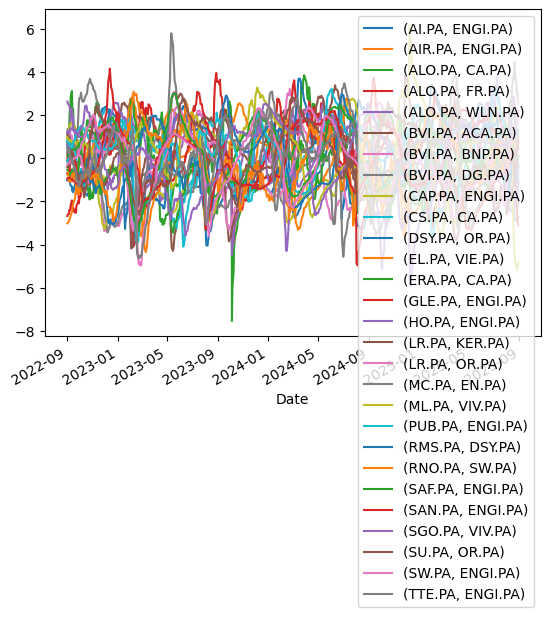

In [201]:
# plot z-scores of each potentially coitegrated pair
z_score_df = signal_df.xs('z_score', axis=1, level=1)
z_score_df.plot()
plt.show()

In [37]:
# portfolio construction using optimal exit threshold
max_sharpe_exit_threshold = metrics_df['Sharpe Ratio'].idxmax()
port = gen_port(signal_df, final_pairs, max_sharpe_exit_threshold)
port

,AAL.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WEIR.L,WIZZ.L,WPP.L,WTB.L,YOU.L
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-01,0.000000,0.000000,0.000000,-0.021846,0.021846,0.000000,0.000000,-0.021846,0.0,0.021846,...,0.000000,-0.019043,0.000000,0.000000,0.006882,0.021846,0.000000,0.021846,0.000000,0.000000
2022-09-02,0.000000,0.000000,0.000000,-0.021221,0.021221,0.000000,0.000000,-0.021221,0.0,0.021221,...,0.000000,-0.019333,0.000000,0.000000,0.006960,0.021221,0.000000,0.021221,0.000000,0.000000
2022-09-05,0.000000,0.000000,0.000000,-0.020747,0.020747,0.000000,0.000000,-0.020747,0.0,0.020747,...,0.000000,-0.019568,0.000000,0.000000,0.007094,0.020747,0.000000,0.020747,0.000000,0.000000
2022-09-06,0.000000,0.000000,0.000000,-0.020373,0.020373,0.000000,0.000000,-0.020373,0.0,0.020373,...,0.000000,-0.019708,0.000000,0.000000,0.007329,0.020373,0.000000,0.020373,-0.020373,0.000000
2022-09-07,0.000000,0.000000,0.000000,-0.019520,0.019520,0.000000,0.000000,-0.019520,0.0,0.019520,...,0.000000,-0.019333,0.000000,0.000000,0.007664,0.019520,0.000000,0.019520,-0.019520,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-22,0.015888,0.000000,-0.015888,-0.015888,0.000000,-0.015888,0.015888,-0.015888,0.0,0.000000,...,0.015888,-0.008032,0.015888,-0.002447,0.024703,0.015888,-0.015888,0.000000,-0.015888,0.015888
2025-08-26,0.015808,0.015808,-0.015808,-0.015808,0.000000,-0.015808,0.015808,-0.015808,0.0,0.000000,...,0.015808,-0.010122,0.015808,-0.002347,0.024450,0.015808,-0.015808,0.000000,-0.015808,0.015808
2025-08-27,0.017271,0.017271,-0.017271,-0.017271,0.000000,-0.017271,0.017271,-0.017271,0.0,0.000000,...,0.017271,-0.011955,0.017271,-0.002486,0.026497,0.017271,0.000000,0.000000,-0.017271,0.000000


<Axes: xlabel='Date'>

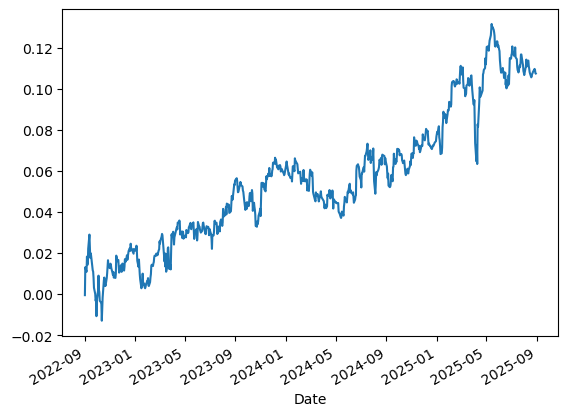

In [39]:
# Calculate out-of-sample daily returns
out_sample_ret = assets_ret.loc[start_of_out_sample:][port.columns]    # filter asset return DataFrame by dates, then by columns with live positions
strat_gross_ret = (port.shift() * out_sample_ret).sum(1)    # sum port returns across columns, generates single timeseries with port returns

# Calculate net returns, net of assumed simplified transaction costs (ignoring dynamic TCA on rolling period)
to = compute_turnover(port)
strat_net_ret = strat_gross_ret.subtract(to * cfg.tcost_bps * 1e-4, fill_value=0)

strat_net_ret.cumsum().plot()

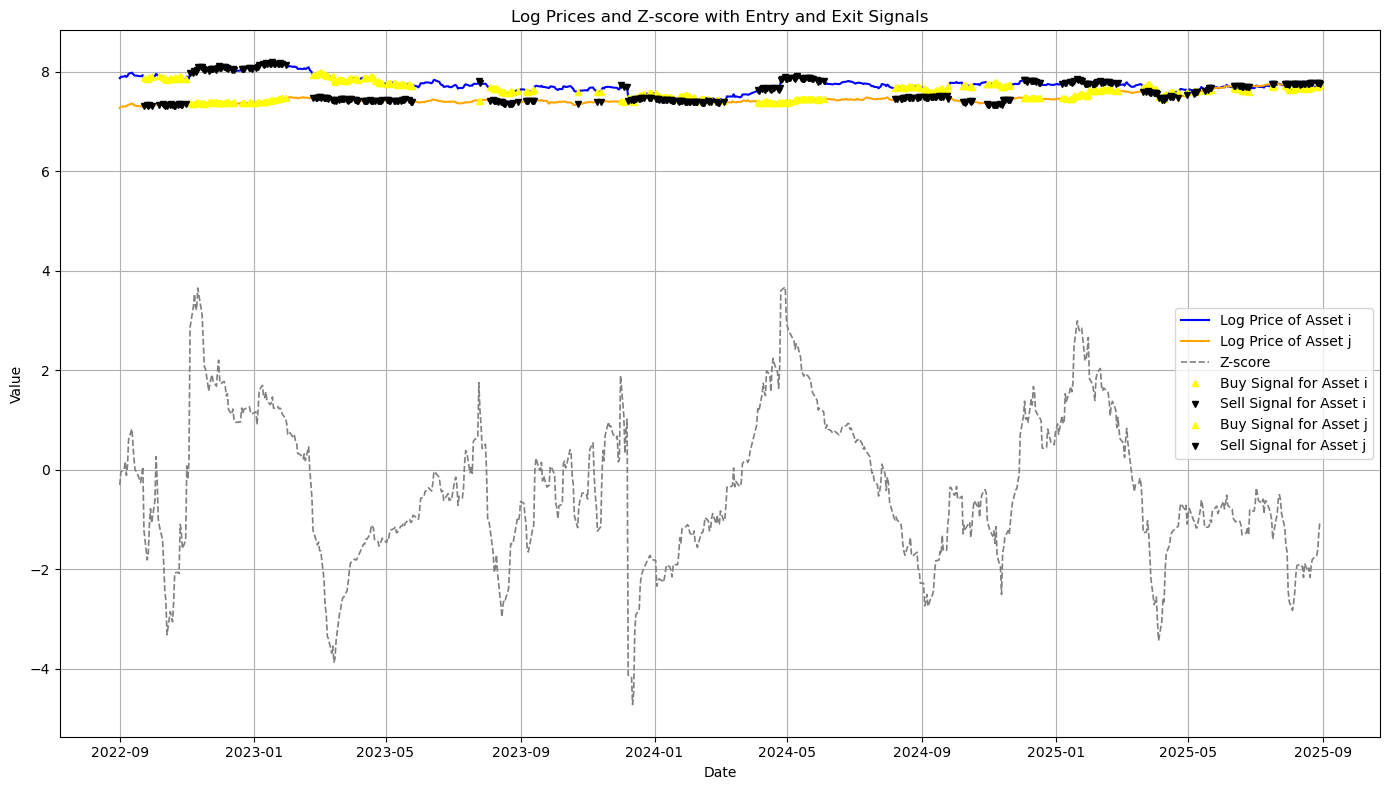

In [41]:
# select the first pair of all potentially cointegrated pairs (for illustration) and visualize its log-prices and z-scores
asset_i, asset_j = final_pairs[0] 
log_px_i = np.log(asset_px.loc[start_of_out_sample:][asset_i])
log_px_j = np.log(asset_px.loc[start_of_out_sample:][asset_j])
z_score = signal_df[(final_pairs[0], 'z_score')]

plot_with_signals(log_px_i, log_px_j, z_score)

Compare the strategy performance against a buy-and-hold strategy for the benchmark index. 

Evaluate key metrics including alpha and beta, maximum drawdowns and maximum drawdown duration of strategy vs index buy-and-hold. 

In [43]:
# Calculate benchmark daily returns 
bm_ret = benchmark_df / benchmark_df.shift() - 1
bm_ret = bm_ret.loc[start_of_out_sample:]

bm_ret = bm_ret.reindex(strat_net_ret.index)

print(benchmark_df) # check price dataframe
print(bm_ret) # check returns dataframe

Ticker            ^FTSE
Date                   
2018-08-30  7516.000000
2018-08-31  7432.399902
2018-09-03  7504.600098
2018-09-04  7457.899902
2018-09-05  7383.299805
...                 ...
2025-08-22  9321.400391
2025-08-26  9265.799805
2025-08-27  9255.500000
2025-08-28  9216.799805
2025-08-29  9187.299805

[1767 rows x 1 columns]
Ticker         ^FTSE
Date                
2022-09-01 -0.018629
2022-09-02  0.018563
2022-09-05  0.000851
2022-09-06  0.001784
2022-09-07 -0.008575
...              ...
2025-08-22  0.001311
2025-08-26 -0.005965
2025-08-27 -0.001112
2025-08-28 -0.004181
2025-08-29 -0.003201

[756 rows x 1 columns]


In [45]:
# Create dictionary of strategy portfolio daily returns and benchmark daily returns over backtesing period
full_sample_ret = pd.DataFrame({
    'strat_ret': strat_net_ret,
    'bm_ret': bm_ret.values.flatten()
})

full_sample_stats = compute_stats(full_sample_ret)
print(full_sample_stats)

                avg       vol    sharpe  hit_rate
strat_ret  0.035789  0.050430  0.709664  0.492063
bm_ret     0.084058  0.115388  0.728480  0.546296


<Axes: xlabel='Date'>

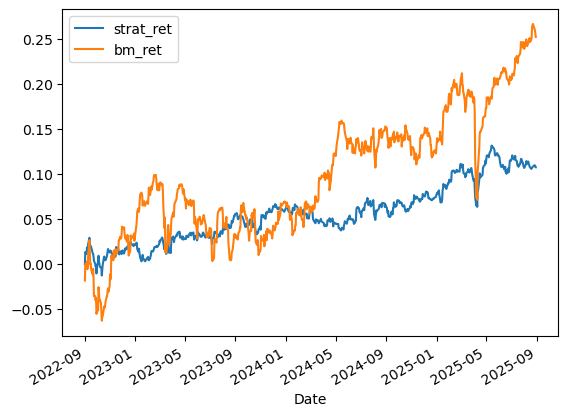

In [47]:
full_sample_ret.cumsum().plot() # print strategy daily returns vs benchmark daily returns

In [49]:
# Calculate the information ratio: measures risk-adjusted alpha, i.e., how consistently the strategy generates excess return beyond beta.

corr = full_sample_ret.rolling(252).corr(full_sample_ret['bm_ret'])
vol = full_sample_ret.rolling(252).std()

beta = (corr*vol).divide(vol['bm_ret'], 0)

# Computing Point-in-Time Residual Returns
resid = full_sample_ret - beta.multiply(full_sample_ret['bm_ret'], axis=0)
print(resid)
print(resid.corr())

# The information ratio
IR = resid.mean()/resid.std()*np.sqrt(252)
print(f"Information ratio is {IR['strat_ret']}")

            strat_ret        bm_ret
Date                               
2022-09-01        NaN           NaN
2022-09-02        NaN           NaN
2022-09-05        NaN           NaN
2022-09-06        NaN           NaN
2022-09-07        NaN           NaN
...               ...           ...
2025-08-22   0.000282 -6.505213e-19
2025-08-26   0.003076  4.336809e-18
2025-08-27  -0.000079  6.505213e-19
2025-08-28  -0.000576  2.602085e-18
2025-08-29   0.000652  2.168404e-18

[756 rows x 2 columns]
           strat_ret    bm_ret
strat_ret   1.000000 -0.019544
bm_ret     -0.019544  1.000000
Information ratio is 0.14343238155252627


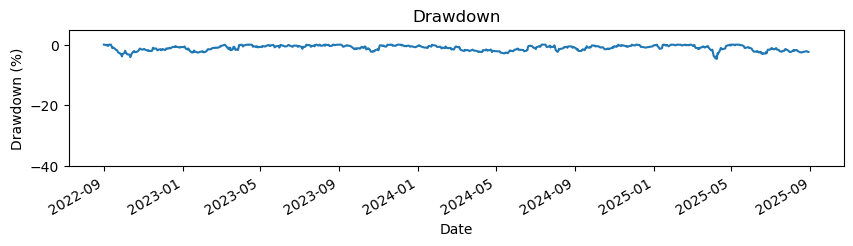

The max drawdown is -4.698662250394076%


In [51]:
# Plot max drawdown
dd = drawdown(full_sample_ret['strat_ret'])*100
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-40, 5)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.show()
print(f"The max drawdown is {dd.min()}%")

In [53]:
# calculates number of consecutive days strategy cumulative return remains below peak
ddd = duration(full_sample_ret.cumsum())
ddd

,strat_ret,bm_ret
Date,,
2022-09-01,0.0,0.0
2022-09-02,0.0,0.0
2022-09-05,1.0,0.0
2022-09-06,0.0,0.0
2022-09-07,1.0,1.0
...,...,...
2025-08-22,71.0,0.0
2025-08-26,72.0,1.0
2025-08-27,73.0,2.0


<Axes: xlabel='Date'>

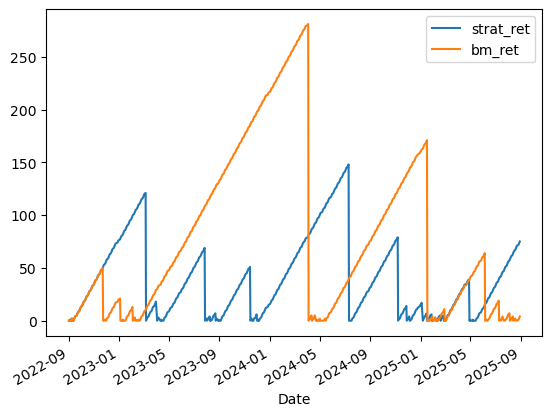

In [55]:
# plot number of consecutive days strategy cumulative return remains below peak
ddd.plot()  

In [57]:
ddd.max()  # calculate maximum drawdown duration

strat_ret    148.0
bm_ret       281.0
dtype: float64

In [59]:
# ----------------
# OUTPUT RESULTS
# ----------------

avg_return = full_sample_stats.loc['strat_ret', 'avg']
volatility = full_sample_stats.loc['strat_ret', 'vol']
sharpe = full_sample_stats.loc['strat_ret', 'sharpe']
hit_rate = full_sample_stats.loc['strat_ret', 'hit_rate']
max_drawdown = dd.min()
max_duration = ddd.max().loc['strat_ret']
holding_period = metrics_df.loc[0.1, 'Holding Period']
information_ratio = IR['strat_ret']

# Calculate strategy stats with formatted percentages and days
stats = final_results(avg_return, volatility, sharpe, hit_rate, max_drawdown, max_duration, holding_period, information_ratio)
print(stats)

                      strategy
Return (Ann.)            3.58%
Volatility (Ann.)        5.04%
Sharpe Ratio              0.71
Hit Rate                49.21%
Max Drawdown            -4.70%
Max Duration       148.00 days
Holding Period      30.84 days
Information Ratio         0.14
